In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA

## Data Exploration


In [3]:
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 101

In [4]:
bucket = 'leaseplan-oct-2019-ml-immersion'
prefix = 'lease-plan'
filename = 'sample_data.csv'
s3_fullpath = os.path.join('s3://', bucket, prefix, 'raw-data', filename)

!aws s3 cp $s3_fullpath .

download: s3://leaseplan-oct-2019-ml-immersion/lease-plan/raw-data/sample_data.csv to ./sample_data.csv


In [5]:
# Read from S3 or local
raw_data = pd.read_csv(filename, header=0, sep=',')

### Analysis

Apparently data for iobjectid = [161541] is corrupted. It can be seen the data is misalligned.

E.g., 'Servicetype = scheduled' is shown under product shorttext
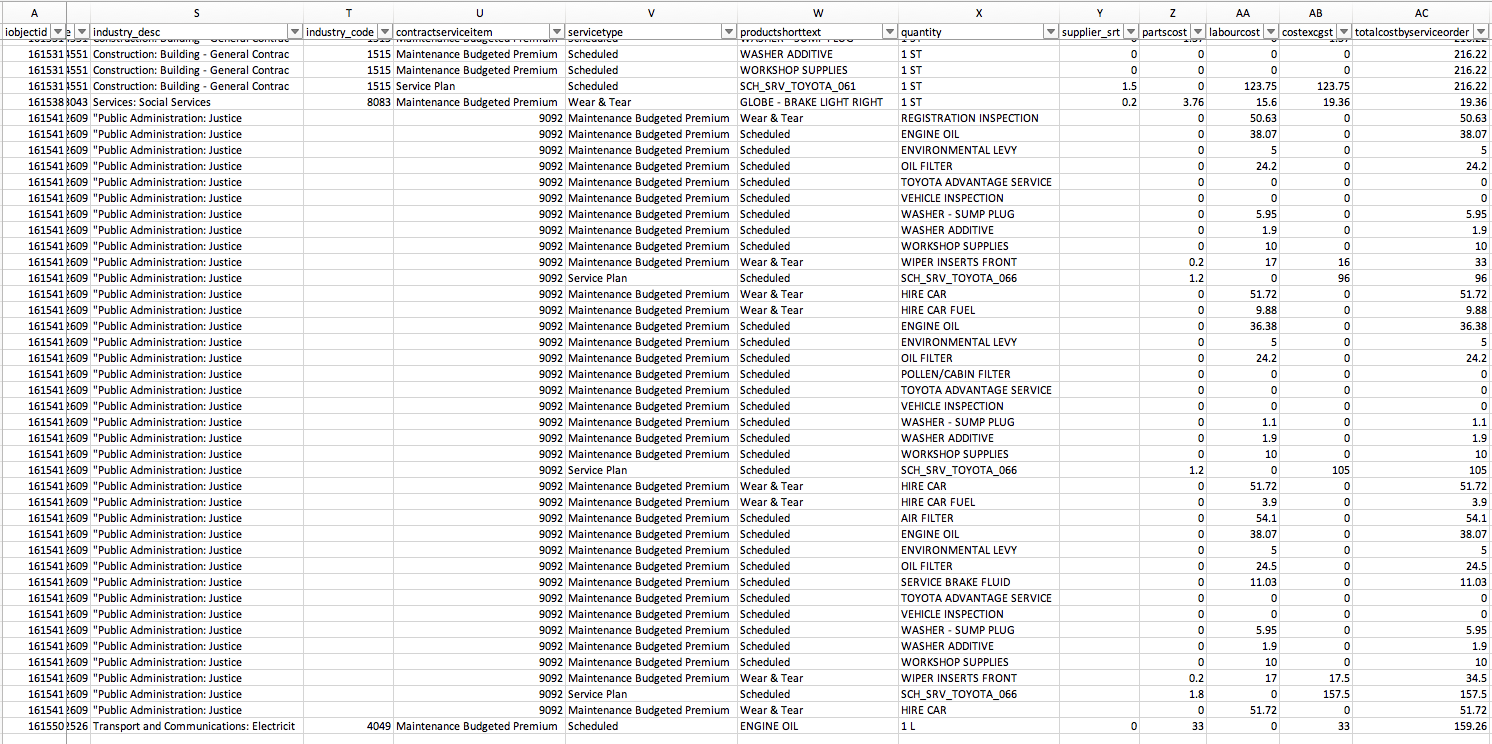

In [8]:
# Drop list of iobjectid that has corrupted data
iobjectid = [161541]
raw_data = raw_data[~raw_data['iobjectid'].isin(iobjectid)]

raw_data.shape

(62, 29)

In [9]:
# Only one column 'serviceinterval' with null value
raw_data.isnull().sum()

iobjectid                  0
jobdate                    0
terminationflag            0
terminationtype            0
contractstartdateorig      0
contractenddate            0
lastknownododate           0
builddate                  0
customertopnode            0
make                       0
model                      0
vehicledesc                0
bodytype                   0
serviceorderid             0
accountingindicator        0
serviceinterval            2
odometer                   0
supplierpostcode           0
industry_desc              0
industry_code              0
contractserviceitem        0
servicetype                0
productshorttext           0
quantity                   0
supplier_srt               0
partscost                  0
labourcost                 0
costexcgst                 0
totalcostbyserviceorder    0
dtype: int64

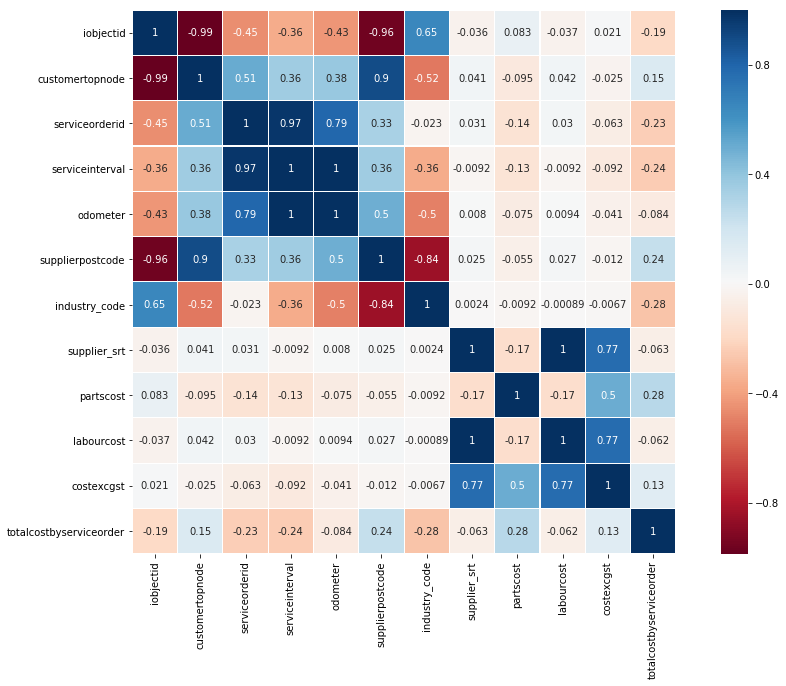

In [10]:
# Check for correlation

# Drop iobjectid which does not tell us much in these sample
# Drop serviceinterval which is highly correlated to serviceorderid, and also contain null
# Drop customertopnode which is highly correlated to iobjectid, and also contain null

import seaborn as sns

plt.figure(figsize=(16, 10))

corr = raw_data.corr()
colormap = plt.cm.RdBu

sns.heatmap(corr, linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)



In [11]:
# This show that 'serviceinterval' info is the same as 'customertopnode'
# Given that 'serviceorderid' is correlated to 'serviceinterval', we can drop 'serviceinterval','customertopnode'

raw_data_gb = raw_data.groupby('serviceorderid')['serviceinterval','customertopnode']

pd.DataFrame(raw_data_gb.count())

,serviceinterval,customertopnode
serviceorderid,,
2800297501,1,1
2801232605,4,4
2801369140,13,13
2801574869,9,9
2801746385,12,12
2801854505,9,9
2801881685,0,1
2802053131,12,12
2802136575,0,1


In [12]:
# Drop columns
drop_columns = ['iobjectid', # does not tell much info, drop for now
                'customertopnode', # highly corrected to iobjectid
                'serviceinterval', # highly Correlated to serviceorderid 
                'terminationflag', #single value: "#"
                 'terminationtype', #single value: "not assigned"
                 'vehicledesc', # text is ignored for now, embedding can be done
                 'accountingindicator', #single value: "budget"
                ]
    
raw_data.drop(drop_columns, axis=1, inplace=True)
raw_data.shape

(62, 22)

In [17]:
# Check that by grouping 'serviceorderid', the total cost is equal to 'totalcostbyserviceorder'
raw_data_gb = raw_data.groupby('serviceorderid')['costexcgst']

total_cost_df = pd.DataFrame(raw_data_gb.sum())
total_cost_df.columns = ['totalcost_check']

new_df = raw_data.merge(total_cost_df, on='serviceorderid')
new_df['unmatched_total'] = np.where((new_df['totalcostbyserviceorder'] - new_df['totalcost_check']).astype(int) != 0, 1, 0)

# Extract numerical quantity without unit
new_df['quantity'] = new_df['quantity'].str.extract('(\d+)')
new_df['quantity'] = new_df['quantity'].fillna(1)

new_df.head()

,jobdate,contractstartdateorig,contractenddate,lastknownododate,builddate,make,model,bodytype,serviceorderid,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,totalcost_check,unmatched_total
0,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER - SUMP PLUG,1,0.000,1.320,0.000,1.320,130.910,75.330,1
1,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER ADDITIVE,1,0.000,0.000,0.000,0.000,130.910,75.330,1
2,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WORKSHOP SUPPLIES,1,0.000,8.010,0.000,8.010,130.910,75.330,1
3,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1,0.800,0.000,66.000,66.000,130.910,75.330,1
4,26JUL2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801369140,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,DIFF OIL,1,0.000,26.100,0.000,26.100,405.410,405.410,0


In [18]:
new_df['cost_ratio'] = new_df['costexcgst'] / new_df['totalcostbyserviceorder']
new_df.head()

,jobdate,contractstartdateorig,contractenddate,lastknownododate,builddate,make,model,bodytype,serviceorderid,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,totalcost_check,unmatched_total,cost_ratio
0,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER - SUMP PLUG,1,0.000,1.320,0.000,1.320,130.910,75.330,1,0.010
1,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WASHER ADDITIVE,1,0.000,0.000,0.000,0.000,130.910,75.330,1,0.000
2,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,WORKSHOP SUPPLIES,1,0.000,8.010,0.000,8.010,130.910,75.330,1,0.061
3,19MAY2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801232605,70136,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1,0.800,0.000,66.000,66.000,130.910,75.330,1,0.504
4,26JUL2011,23OCT2009,22OCT2012,06SEP2012,01SEP2009,Toyota,Hiace,Van,2801369140,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Scheduled,DIFF OIL,1,0.000,26.100,0.000,26.100,405.410,405.410,0,0.064
